In [580]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import jaccard_score, f1_score, accuracy_score, log_loss
from sklearn import neighbors
from sklearn import preprocessing

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 

In [2]:
matplotlib.rcParams.update({'font.size': 16})

In [3]:
df = pd.read_csv('train.csv')
print(df.shape)
no_passengers = df.shape[0]
print(df.dtypes)
df[0:5]

(891, 12)
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# OVERALL SURVIVAL RATE

In [4]:
survival_arr = df['Survived'].value_counts().sort_index()
survivalrate = survival_arr[1]/np.sum(survival_arr)
print('Overall survival rate: ', f'{survivalrate:.3f}')

Overall survival rate:  0.384


# MISSING DATA

## Port of Embarkation

In [5]:
df[df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [6]:
df2 = df.loc[:,['Pclass','Fare','Embarked']]
df2.dropna(inplace=True)
df2[df2['Embarked'].isnull() == True]

X = np.array(df2.loc[:,['Pclass','Fare']])
scaler = preprocessing.StandardScaler().fit(X)
scaled_data = scaler.transform(X)
emb_dum = pd.get_dummies(df2['Embarked'])
ports = emb_dum.columns.values
y = np.array(emb_dum)

In [7]:
clf = tree.DecisionTreeClassifier()
clf.fit(scaled_data, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [8]:
x = scaler.transform(np.array([1,80]).reshape(1,-1))
print(ports)
clf.predict(x)

['C' 'Q' 'S']


array([[0, 0, 1]], dtype=uint8)

In [9]:
df['Embarked'].fillna('S', inplace=True)

In [10]:
df[df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


## Age

In [11]:
df[df['Age'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


In [12]:
nullage = list(df[df['Age'].isnull()].index)
nullage[0:5]

[5, 17, 19, 26, 28]

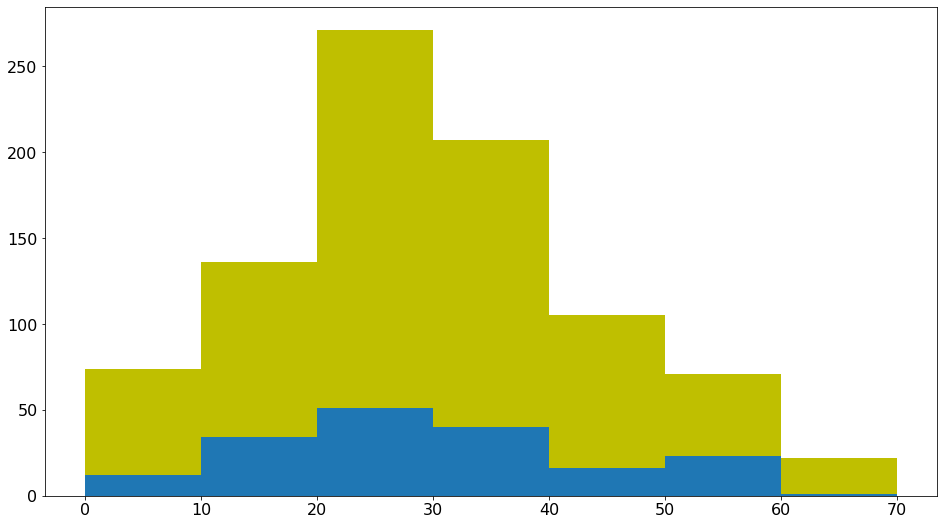

In [13]:
df2 = df.loc[:,['Pclass','Sex','SibSp','Parch','Fare','Embarked','Age']]

df2['Sex'].replace(['female','male'],[0,1],inplace=True)
df2['Embarked'].replace(['C','Q','S'],[0,1,2],inplace=True)
df3 = df2.copy()

df2.dropna(inplace=True)
data = np.array(df2)
X = data[:,:6]
y = data[:,6]
n_neighbors = 3

scaler = preprocessing.StandardScaler().fit(X)

T = np.array(df3[df3['Age'].isnull()])
T = scaler.transform(T[:,:6])
X = scaler.transform(X)

knn = neighbors.KNeighborsRegressor(n_neighbors,weights='distance',algorithm='brute',n_jobs=-1)
knn.fit(X,y)

plt.figure(figsize=(16,9))
df.iloc[nullage,5] = knn.predict(T)
plt.hist(df['Age'],color='y',bins=np.arange(0,80,10))
plt.hist(knn.predict(T),bins=np.arange(0,80,10))
df.iloc[nullage,5] = knn.predict(T)

plt.show()

In [14]:
df[df['Age'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [210]:
model = []

# BY SEX

In [15]:
sexes = ['male','female']
bysex = np.zeros((2,2))
for i in range(0,len(sexes)):
    bysex[i] = df[df['Sex'] == sexes[i]]['Survived'].value_counts().sort_index()
bysex

array([[468., 109.],
       [ 81., 233.]])

In [16]:
males_rate = bysex[0][1]/np.sum(bysex[0])
females_rate = bysex[1][1]/np.sum(bysex[1])
print('Survival rate of:')
print('\tmales:\t\t',f'{males_rate:.3f}')
print('\tfemales:\t',f'{females_rate:.3f}')

Survival rate of:
	males:		 0.189
	females:	 0.742


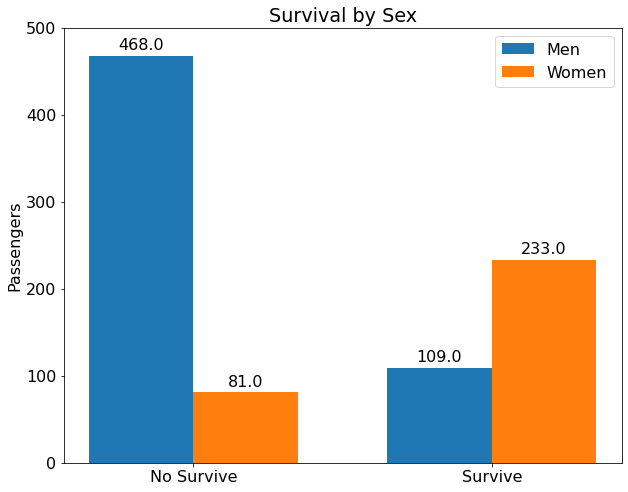

In [17]:
labels = ['No Survive', 'Survive']
male = bysex[0]
female = bysex[1]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,8))
rects1 = ax.bar(x - width/2, male, width, label='Men')
rects2 = ax.bar(x + width/2, female, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Passengers')
ax.set_title('Survival by Sex')
ax.set_xticks(x)
ax.set_ylim(0,500)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

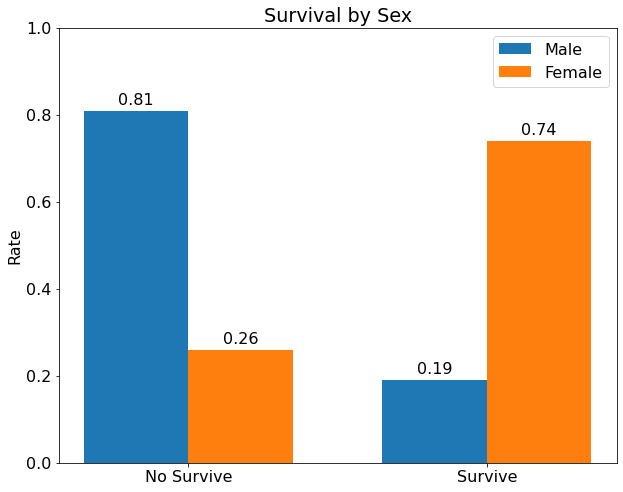

In [18]:
labels = ['No Survive', 'Survive']
male = np.round(bysex[0]/np.sum(bysex[0]),2)
female = np.round(bysex[1]/np.sum(bysex[1]),2)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,8))
rects1 = ax.bar(x - width/2, male, width, label='Male')
rects2 = ax.bar(x + width/2, female, width, label='Female')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Rate')
ax.set_title('Survival by Sex')
ax.set_xticks(x)
ax.set_ylim(0,1)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)

plt.show()

In [19]:
df['male'] = df['Sex'] == 'male'
df['male'].replace([True,False],[1,0],inplace=True)
X = np.array(df['male'])
y = np.array(df['Survived'])

len(y)

891

In [20]:
stats.pearsonr(X,y)

(-0.5433513806577572, 1.406066130876717e-69)

In [211]:
model.append('male')
model

['male']

#### Discussion
There is a statistically significant indirect correlation between being a male and survival. Our model should include whether or not the passenger is male.

# BY PORT of EMBARKATION


In [212]:
df['Embarked'].replace(np.nan,'S',inplace=True)
ports = df['Embarked'].unique()

In [213]:
byport = np.zeros((len(ports),2))
byport
for i in range(0,len(ports)):
    byport[i] = df[df['Embarked'] == ports[i]]['Survived'].value_counts().sort_index()

In [214]:
print('Survival rate of:')
for i in range(0,len(ports)):
    print(f'\t{ports[i]}: {byport[i][1]/np.sum(byport[i]):.2f}')

Survival rate of:
	S: 0.34
	C: 0.55
	Q: 0.39


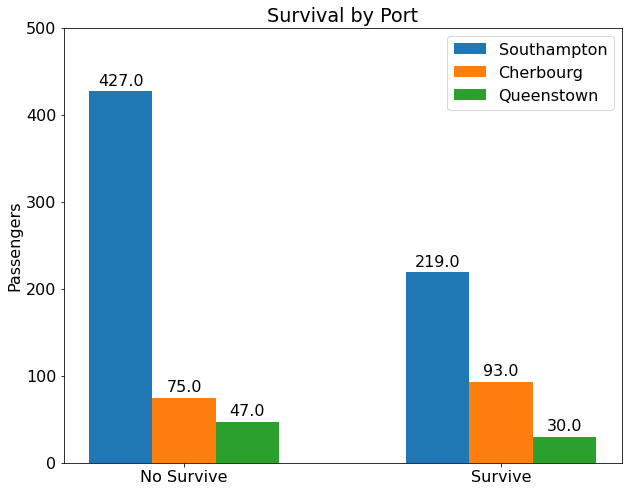

In [215]:
labels = ['No Survive', 'Survive']
S = byport[0]
C = byport[1]
Q = byport[2]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10,8))
rects1 = ax.bar(x - width, S, width, label='Southampton')
rects2 = ax.bar(x , C, width, label='Cherbourg')
rects3 = ax.bar(x + width, Q, width, label='Queenstown')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Passengers')
ax.set_title('Survival by Port')
ax.set_xticks(x)
ax.set_ylim(0,500)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()

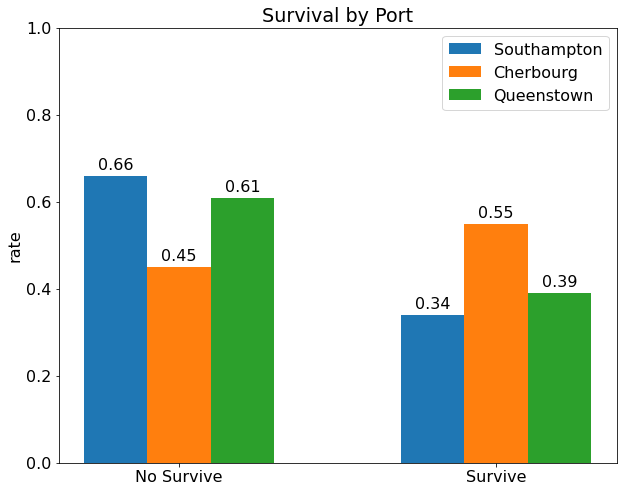

In [216]:

labels = ['No Survive', 'Survive']
S = np.round(byport[0]/np.sum(byport[0]),2)
C = np.round(byport[1]/np.sum(byport[1]),2)
Q = np.round(byport[2]/np.sum(byport[2]),2)

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10,8))
rects1 = ax.bar(x - width, S, width, label='Southampton')
rects2 = ax.bar(x , C, width, label='Cherbourg')
rects3 = ax.bar(x + width, Q, width, label='Queenstown')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('rate')
ax.set_title('Survival by Port')
ax.set_xticks(x)
ax.set_ylim(0,1)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()

In [217]:
len(y)

891

In [218]:
model

['male']

In [219]:
portdum = pd.get_dummies(df['Embarked'])
ports = np.array(portdum.columns)
X = np.array(portdum)
for i in range(0,3):
    if stats.pearsonr(X[:,i],y)[0] < 0.05:
        print(f'Embarked {ports[i]}:')
        print(f'\tcorr {stats.pearsonr(X[:,i],y)[0]:.3f}')
        print(f'\tp-value {stats.pearsonr(X[:,i],y)[1]:.3e}')
        model.append(f'port_{ports[i]}')
        print()

Embarked Q:
	corr 0.004
	p-value 9.134e-01

Embarked S:
	corr -0.150
	p-value 7.223e-06



#### Discussion
These values suggest that embarking at Cherbourg has a statistically significant direct correlation with surviving. Southampton has a similar indirect correlation. There is no statisically significant correlation between embarking at Queenstown and survival. Our model should include whether the passenger embarked at Cherbourg or Southampton.

# BY DECK

In [220]:
df[0:3]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,male,deck,nickname,family,title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,??,S,1,?,False,Braund,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,C,False,Cumings,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,??,S,0,?,False,Heikkinen,Miss


In [221]:
df['Cabin'].replace(np.nan,'??',inplace=True)
def get_deck(cabin):
    return str(cabin)[0]
df['deck'] = df['Cabin'].apply(get_deck)

In [222]:
decks = df['deck'].unique()
decks.sort()

In [223]:
bydeck = np.zeros((len(decks),2))
for i in range(0,len(decks)):
    if len(df[df['deck'] == decks[i]]['Survived']) > 1:
        bydeck[i] = df[df['deck'] == decks[i]]['Survived'].value_counts().sort_index()
    elif df[df['deck'] == decks[8]]['Survived'].value_counts().index[0] == 0:
        bydeck[i] = [df[df['deck'] == decks[8]]['Survived'].value_counts(),0]

In [224]:
print('Survival rate of:')
for i in range(0,len(decks)):
    print(f'\tDeck {decks[i]}: {bydeck[i][1]/np.sum(bydeck[i]):.2f}')

Survival rate of:
	Deck ?: 0.30
	Deck A: 0.47
	Deck B: 0.74
	Deck C: 0.59
	Deck D: 0.76
	Deck E: 0.75
	Deck F: 0.62
	Deck G: 0.50
	Deck T: 0.00


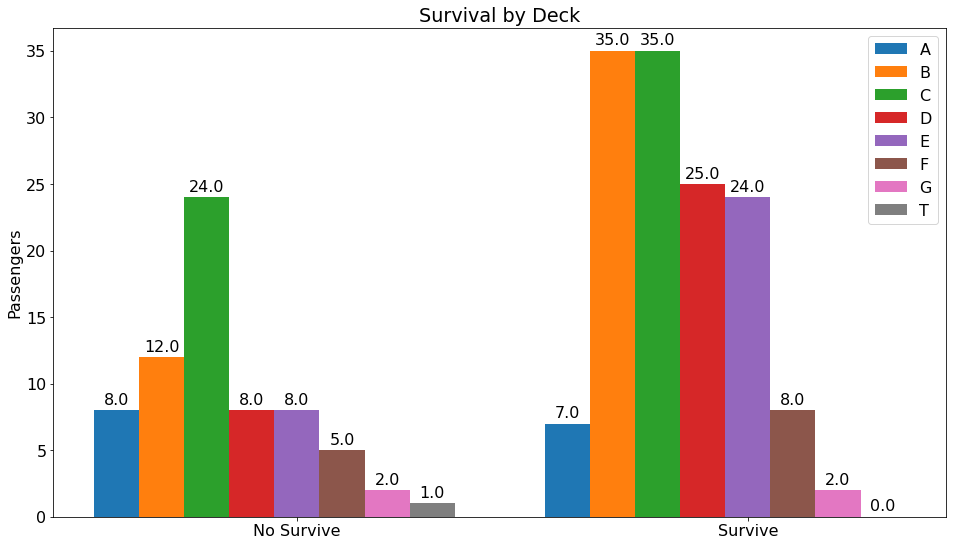

In [225]:
labels = ['No Survive', 'Survive']

x = np.arange(0,2)  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots(figsize=(16,9))

for i in range(1,len(decks)):
    b = ax.bar(x + (i-5)*width/5, bydeck[i], width/5, label=decks[i])
    autolabel(b)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Passengers')
ax.set_title('Survival by Deck')
ax.set_xticks(x)
#ax.set_ylim(0,505)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

In [226]:
# A snippet to generate distinct colors for our clusters.
import colorsys
N = 2*len(np.unique(decks))
print('colors: {}'.format(N))
rgb_list = []
HSV_tuples = []
for x in range(1,N+1):
    if (x%2 == 0):
        HSV_tuples.append(((x-1)*1.0/N, 1.0, 0.325))
    else:
        HSV_tuples.append((x*1.0/N, 1.0, 0.75))
RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
for rgb in RGB_tuples:
        color = [int(255*rgb[0]),int(255*rgb[1]),int(255*rgb[2])]
        hxstr = '#'
        for c in color:
            hxstr = hxstr + '{0:0{1}X}'.format(c,2)
        rgb_list.append(hxstr)    


colors: 18


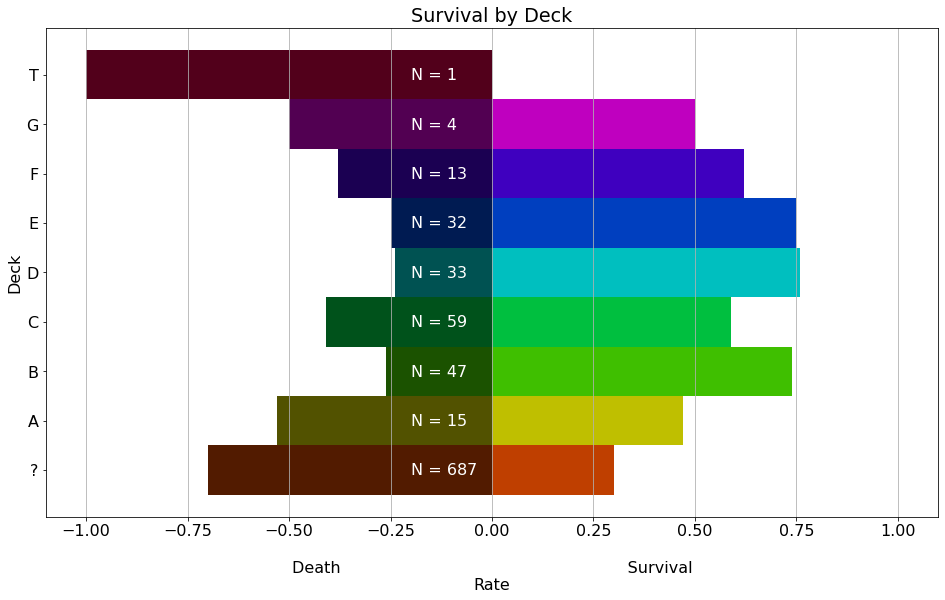

In [227]:
x = np.arange(-2.0,2.0)  # the label locations
width = 5.0  # the width of the bars

fig, ax = plt.subplots(figsize=(16,9))
rects = []
for i in range(0,len(decks)):
    b = plt.barh(i, np.round(bydeck[i,1]/np.sum(bydeck[i]),2), width/5, label=decks[i],color=rgb_list[2*i])
    nb = plt.barh(i, -np.round(bydeck[i,0]/np.sum(bydeck[i]),2), width/5, label=decks[i],color=rgb_list[2*i+1])
    plt.annotate(f'N = {str(int(np.sum(bydeck[i])))}',xy=[-0.20,i-0.1],c='white')
    rects.append(b)
ax.set_xlabel('\nDeath                                                        Survival\nRate')
ax.set_ylabel('Deck')
ax.set_title('Survival by Deck')
ax.set_yticks(range(0,9))
ax.set_xlim(-1.1,1.1)
ax.set_yticklabels(decks)
ax.grid(axis='x')
plt.show()

In [231]:
deckdum = pd.get_dummies(df['deck'])
decks = np.array(deckdum.columns)
X = np.array(deckdum)
for i in range(0,len(decks)):
    pr = stats.pearsonr(X[:,i],y)
    significant = ( pr[1] < 0.05)
    if significant:
        print(f'Deck {decks[i]} ')
        print(f'\tcorr {pr[0]:.3f}')
        print(f'\tp-value {pr[1]:.3e}')
        print(f'\tSignificant: {significant}')
        model.append(f'deck_{decks[i]}')
        print('+------------------------+')

Deck ? 
	corr -0.317
	p-value 3.091e-22
	Significant: True
+------------------------+
Deck B 
	corr 0.175
	p-value 1.442e-07
	Significant: True
+------------------------+
Deck C 
	corr 0.115
	p-value 6.062e-04
	Significant: True
+------------------------+
Deck D 
	corr 0.151
	p-value 6.233e-06
	Significant: True
+------------------------+
Deck E 
	corr 0.145
	p-value 1.332e-05
	Significant: True
+------------------------+


#### Discussion
There is a statistically significant correlation between staying on Deck B, C, D, E and survival. Conversely, if the deck of the passenger is unknown there is a correlation with not surviving. There is no significant correlation for the other decks A, F, G, & T. The significant decks should be included in our model.

# BY AGE

In [232]:
model

['male', 'port_Q', 'port_S', 'deck_?', 'deck_B', 'deck_C', 'deck_D', 'deck_E']

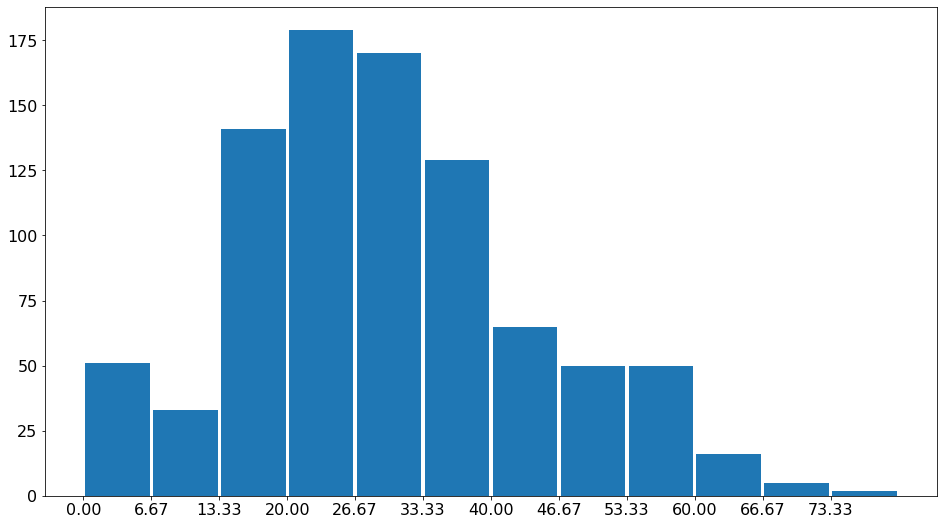

In [233]:
nbins = 12
ylim = df['Age'].max()
binwidth= ylim/nbins

bins = np.arange(0,ylim,binwidth)


thedigital = np.digitize(df['Age'],bins,right=True)
thecount = np.bincount(thedigital)

#print(age_cts)
plt.figure(figsize=(16,9))
plt.bar(bins+binwidth/2,thecount[1:],width=binwidth*0.95)
plt.xticks(bins)
plt.show()

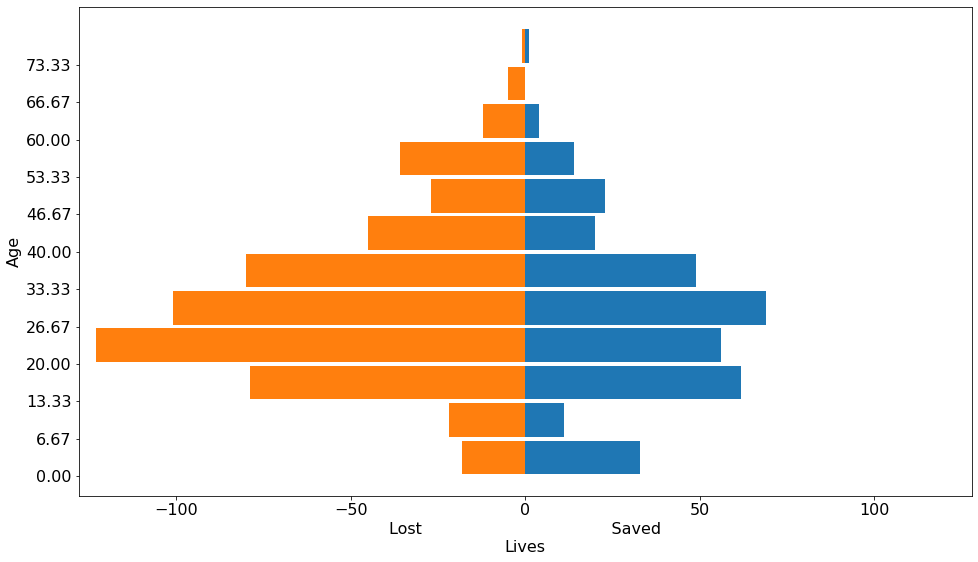

In [234]:
dig_sur = np.digitize(df[df['Survived'] == 1]['Age'],bins,right=True)
freq_sur = np.bincount(dig_sur,minlength=len(bins)+1)

dig_die = np.digitize(df[df['Survived'] == 0]['Age'],bins,right=True)
freq_die = np.bincount(dig_die,minlength=len(bins)+1)

xmax = freq_die.max()+5
xlim = [-xmax,xmax]

plt.figure(figsize=(16,9))
plt.barh(bins+binwidth/2,freq_sur[1:],height=binwidth*0.9)
plt.barh(bins+binwidth/2,-freq_die[1:],height=binwidth*0.9)
plt.xlim(xlim)
plt.yticks(bins)
plt.ylabel('Age')
plt.xlabel('Lost                                     Saved\nLives')

plt.show()

In [235]:
age_arr = np.zeros((len(df),len(bins)+1))

for i in range(0,len(df)):
    for j in range(0,len(bins)):
        if (df['Age'][i] > bins[j]) & (df['Age'][i] <= bins[j]+binwidth):
            age_arr[i,j] = 1
            break
print(bins.astype(int))
print(age_arr[0:10].astype(int))

[ 0  6 13 20 26 33 40 46 53 60 66 73]
[[0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0]]


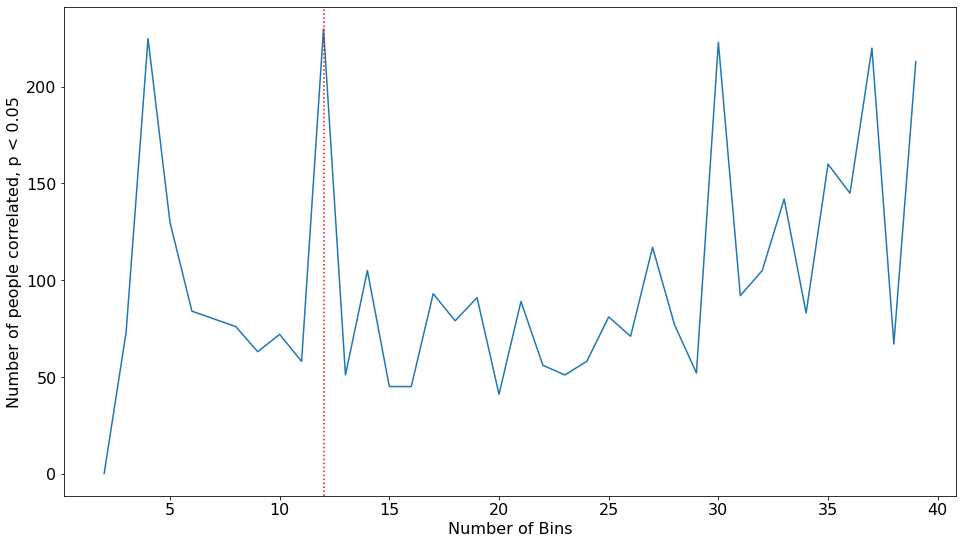

In [236]:
list = []
for nb in range(2,int(ylim/2)):

    _binwidth = ylim/nb
    _bins = np.arange(0,ylim,_binwidth)
    _age_arr = np.zeros((len(df),len(_bins)+1))
    for i in range(0,len(df)):
        for j in range(0,len(_bins)):
            if (df['Age'][i] > _bins[j]) & (df['Age'][i] <= _bins[j]+_binwidth):

                _age_arr[i,j] = 1
                break
    _X = _age_arr
    _total = 0
    for i in range(0,_age_arr.shape[1]-1):
        if stats.pearsonr(_X[:,i],y)[1] < 0.05:
            _total = _total + np.sum(_X[:,i])
    list.append([nb,_total])   
data= np.array(list)
plt.figure(figsize=(16,9))
plt.plot(data[:,0],data[:,1])
plt.axvline(12,color='r',linestyle=':')
plt.ylabel('Number of people correlated, p < 0.05')
plt.xlabel('Number of Bins')
plt.show()

In [245]:
f'{bins[4]:.1f}'

'26.7'

In [246]:
bins = np.arange(0,ylim,binwidth)
X = age_arr
total = 0
for i in range(0,age_arr.shape[1]):
    significant = False
    if stats.pearsonr(X[:,i],y)[1] < 0.05:
        significant = True
        print(f'i = {i}')
        print(f'Age {bins[i]:.1f} : {bins[i]+binwidth:.1f} ')
        print(f'\tcorr {stats.pearsonr(X[:,i],y)[0]:.3f}')
        print(f'\tp-value {stats.pearsonr(X[:,i],y)[1]:.3f}')
        print(f'\tSignificant: {significant}')
        print(f'\tPassengers: {np.sum(X[:,i])}')
        model.append(f'{bins[i]:.0f}_{bins[i]+binwidth:.0f}')
        total = total + np.sum(X[:,i])
        print('+------------------------+')       

print(total)

i = 0
Age 0.0 : 6.7 
	corr 0.133
	p-value 0.000
	Significant: True
	Passengers: 51.0
+------------------------+
i = 3
Age 20.0 : 26.7 
	corr -0.073
	p-value 0.029
	Significant: True
	Passengers: 179.0
+------------------------+
230.0


In [247]:
model

['male',
 'port_Q',
 'port_S',
 'deck_?',
 'deck_B',
 'deck_C',
 'deck_D',
 'deck_E',
 '0_7',
 '20_27']

# Discussion

There is a statistically significant correlation for two age groups.

# BY TICKET PREFIX

In [159]:
def get_prefix(PD_SERIES):
    splt = PD_SERIES.split(' ')
    tmp = splt
    if len(splt) > 1:      
        tmp = splt[0]
        tmp = tmp.replace('STON/O2','SOTON/O2')
        tmp = tmp.replace('STON/O','SOTON/O2')
        tmp = tmp.replace('O2.','O2')

        tmp = tmp.upper()
    else:
        tmp = ''
    return tmp

In [160]:
df['Ticket'].apply(get_prefix).value_counts()


              665
PC             60
C.A.           27
SOTON/O2       20
A/5            10
W./C.           9
SC/PARIS        9
SOTON/O.Q.      8
CA.             8
SOTON/OQ        7
A/5.            7
CA              6
S.O.C.          5
F.C.C.          5
C               5
A/4             3
A/4.            3
S.O./P.P.       3
PP              3
SC/AH           3
A.5.            2
A./5.           2
S.C./PARIS      2
WE/P            2
P/PP            2
W.E.P.          1
S.O.P.          1
FA              1
SW/PP           1
A4.             1
C.A./SOTON      1
S.P.            1
SC              1
W/C             1
S.C./A.4.       1
S.W./PP         1
A/S             1
SO/C            1
SCO/W           1
F.C.            1
Name: Ticket, dtype: int64

#### Discussion

This is a waste of time. There aren't enough passengers with any specific prefix to make any inference about the group.

# BY TITLE

In [89]:
df['title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].replace(' ',''))
df['title'].value_counts()

Mr             517
Miss           182
Mrs            125
Master          40
Dr               7
Rev              6
Mlle             2
Major            2
Col              2
Jonkheer         1
theCountess      1
Capt             1
Ms               1
Don              1
Lady             1
Mme              1
Sir              1
Name: title, dtype: int64

In [186]:
miss = ['Ms','Mlle']
mrs = ['Mme', 'Lady']
prestigious = ['Dr','Rev','Major','Col','Sir','theCountess','Capt','Jonkheer','Don']

df['title'] = df['title'].replace(miss,'Miss')
df['title'] = df['title'].replace(mrs,'Mrs')
df['title'] = df['title'].replace(prestigious,'Prestigious')

In [187]:
df['title'].value_counts()

Mr             517
Miss           185
Mrs            127
Master          40
Prestigious     22
Name: title, dtype: int64

In [191]:
titles = df['title'].value_counts().index.tolist()
bytitle = np.zeros((len(titles),2))
for i in range(0,len(titles)):
    bytitle[i] = df[df['title'] == titles[i]]['Survived'].value_counts().sort_index()

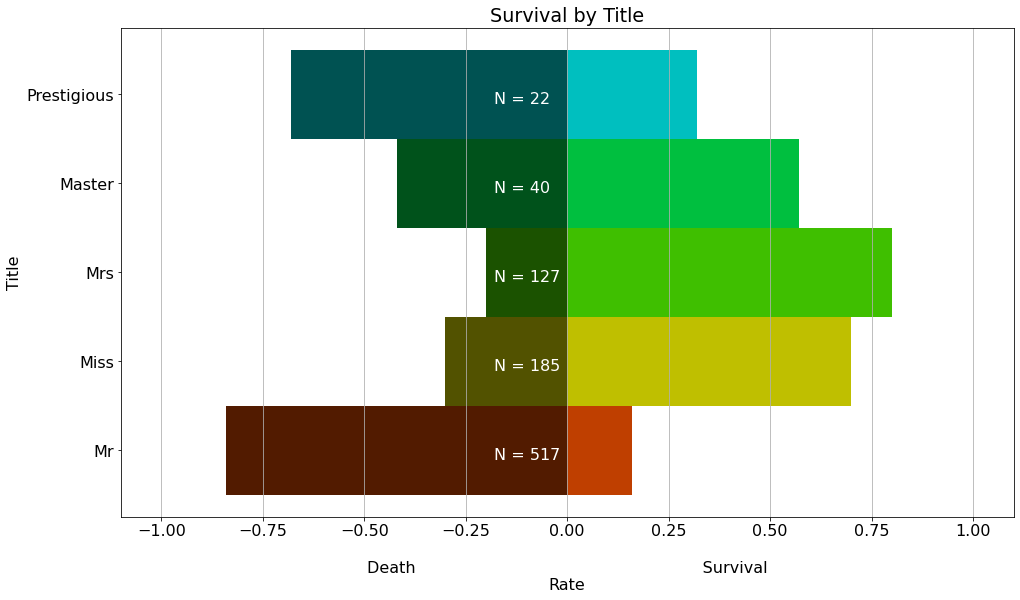

In [192]:
x = np.arange(-2.0,2.0)  # the label locations
width = 5.0  # the width of the bars

fig, ax = plt.subplots(figsize=(16,9))
rects = []
for i in range(0,len(titles)):
    b = plt.barh(i, np.round(bytitle[i,1]/np.sum(bytitle[i]),2), width/5, label=titles[i],color=rgb_list[2*i])
    nb = plt.barh(i, -np.round(bytitle[i,0]/np.sum(bytitle[i]),2), width/5, label=titles[i],color=rgb_list[2*i+1])
    rects.append(b)
    plt.annotate(f'N = {str(int(np.sum(bytitle[i])))}',xy=[-0.18,i-0.1],c='white')
ax.set_xlabel('\nDeath                                                        Survival\nRate')
ax.set_ylabel('Title')
ax.set_title('Survival by Title')
ax.set_yticks(range(0,len(titles)))
ax.set_xlim(-1.1,1.1)
ax.set_yticklabels(titles)
ax.grid(axis='x')
plt.show()

In [134]:
tit_arr = np.zeros((len(df),len(titles)))
for i in range(0,len(df)):
    for j in range(0,len(titles)):
        if df['title'][i] == titles[j]:
            tit_arr[i,j] = 1
            break
tit_arr[0:5]

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [249]:
X = tit_arr
total = 0
for i in range(0,tit_arr.shape[1]):
    significant = False
    if stats.pearsonr(X[:,i],y)[1] < 0.05:
        significant = True
        print(f'i = {i}')
        print(f'Title {titles[i]} ')
        print(f'\tcorr {stats.pearsonr(X[:,i],y)[0]:.2f}')
        print(f'\tp-value {stats.pearsonr(X[:,i],y)[1]:.1e}')
        print(f'\tSignificant: {significant}')
        print(f'\tPassengers: {np.sum(X[:,i])}')
        model.append(f'{titles[i]}')
        total = total + np.sum(X[:,i])
        print('+------------------------+')       

print(total)

i = 0
Title Mr 
	corr -0.55
	p-value 2.4e-71
	Significant: True
	Passengers: 517.0
+------------------------+
i = 1
Title Miss 
	corr 0.34
	p-value 6.7e-25
	Significant: True
	Passengers: 185.0
+------------------------+
i = 2
Title Mrs 
	corr 0.34
	p-value 2.7e-26
	Significant: True
	Passengers: 127.0
+------------------------+
i = 3
Title Master 
	corr 0.09
	p-value 1.1e-02
	Significant: True
	Passengers: 40.0
+------------------------+
869.0


# BY SIBSP

In [193]:
df['SibSp'].value_counts().sort_index().tolist()

[608, 209, 28, 16, 18, 5, 7]

In [194]:
sbsps = np.array(df['SibSp'].value_counts().sort_index().index)
bysbsp = np.zeros([len(sbsps),2])
for i in range(0,len(sbsps)):
    bysbsp[i] = df[df['SibSp'] == sbsps[i]]['Survived'].value_counts().sort_index()

In [195]:
print('Survival rate of SibSp')
for i in range(0,len(sbsps)):
    print(f'\t = {sbsps[i]}: {bysbsp[i][1]/np.sum(bysbsp[i]):.2f}')

Survival rate of SibSp
	 = 0: 0.35
	 = 1: 0.54
	 = 2: 0.46
	 = 3: 0.25
	 = 4: 0.17
	 = 5: 0.50
	 = 8: 0.50


In [196]:
ssp_arr = np.zeros((len(df),len(sbsps)))
for i in range(0,len(df)):
    for j in range(0,len(sbsps)):
        if df['SibSp'][i] == sbsps[j]:
            ssp_arr[i,j] = 1
            break
ssp_arr[0:5]

array([[0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]])

In [250]:
X = ssp_arr
total = 0
for i in range(0,ssp_arr.shape[1]):
    significant = False
    if stats.pearsonr(X[:,i],y)[1] < 0.05:
        significant = True
        print(f'i = {i}')
        print(f'SibSp: {sbsps[i]} ')
        print(f'\tcorr {stats.pearsonr(X[:,i],y)[0]:.2f}')
        print(f'\tp-value {stats.pearsonr(X[:,i],y)[1]:.1e}')
        print(f'\tSignificant: {significant}')
        print(f'\tPassengers: {np.sum(X[:,i])}')
        model.append(f'sbsp_{sbsps[i]}')
        total = total + np.sum(X[:,i])
        print('+------------------------+')       

print(total)

i = 0
SibSp: 0 
	corr -0.12
	p-value 5.3e-04
	Significant: True
	Passengers: 608.0
+------------------------+
i = 1
SibSp: 1 
	corr 0.17
	p-value 2.0e-07
	Significant: True
	Passengers: 209.0
+------------------------+
i = 6
SibSp: 8 
	corr -0.07
	p-value 3.6e-02
	Significant: True
	Passengers: 7.0
+------------------------+
824.0


In [251]:
model

['male',
 'port_Q',
 'port_S',
 'deck_?',
 'deck_B',
 'deck_C',
 'deck_D',
 'deck_E',
 '0_7',
 '20_27',
 'Mr',
 'Miss',
 'Mrs',
 'Master',
 'sbsp_0',
 'sbsp_1',
 'sbsp_8']

# BY PARCH

In [198]:
parchs = np.array(df['Parch'].value_counts().sort_index().index)
byparch = np.zeros([len(parchs),2])
for i in range(0,len(parchs)):
    byparch[i] = df[df['Parch'] == parchs[i]]['Survived'].value_counts().sort_index()

In [199]:
print('Survival rate of: Parch')
for i in range(0,len(parchs)):
    print(f'\t = {parchs[i]}: {byparch[i][1]/np.sum(byparch[i]):.2f}')

Survival rate of: Parch
	 = 0: 0.34
	 = 1: 0.55
	 = 2: 0.50
	 = 3: 0.60
	 = 4: 0.50
	 = 5: 0.20
	 = 6: 0.50


In [200]:
pch_arr = np.zeros((len(df),len(parchs)))
for i in range(0,len(df)):
    for j in range(0,len(parchs)):
        if df['Parch'][i] == parchs[j]:
            pch_arr[i,j] = 1
            break
pch_arr[0:5]

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]])

In [252]:
X = pch_arr
total = 0
for i in range(0,pch_arr.shape[1]):
    significant = False
    if stats.pearsonr(X[:,i],y)[1] < 0.05:
        significant = True
        print(f'i = {i}')
        print(f'Parch: {parchs[i]} ')
        print(f'\tcorr {stats.pearsonr(X[:,i],y)[0]:.2f}')
        print(f'\tp-value {stats.pearsonr(X[:,i],y)[1]:.1e}')
        print(f'\tSignificant: {significant}')
        print(f'\tPassengers: {np.sum(X[:,i])}')
        model.append(f'pa_{parchs[i]}')
        total = total + np.sum(X[:,i])
        print('+------------------------+')       

print(total)

i = 0
Parch: 0 
	corr -0.15
	p-value 1.0e-05
	Significant: True
	Passengers: 678.0
+------------------------+
i = 1
Parch: 1 
	corr 0.13
	p-value 5.9e-05
	Significant: True
	Passengers: 118.0
+------------------------+
i = 2
Parch: 2 
	corr 0.08
	p-value 2.5e-02
	Significant: True
	Passengers: 80.0
+------------------------+
876.0


# BY PCLASS

In [202]:
pcls = np.array(df['Pclass'].value_counts().sort_index().index)
pcls

array([1, 2, 3])

In [203]:
pcls_arr = np.zeros((len(df),len(pcls)))
for i in range(0,len(df)):
    for j in range(0,len(pcls)):
        if df['Pclass'][i] == pcls[j]:
            pcls_arr[i,j] = 1
            break
pcls_arr[0:5]

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [253]:
X = pcls_arr
total = 0
for i in range(0,pcls_arr.shape[1]):
    significant = False
    if stats.pearsonr(X[:,i],y)[1] < 0.05:
        significant = True
        print(f'i = {i}')
        print(f'Pclass: {pcls[i]} ')
        print(f'\tcorr {stats.pearsonr(X[:,i],y)[0]:.2f}')
        print(f'\tp-value {stats.pearsonr(X[:,i],y)[1]:.1e}')
        print(f'\tSignificant: {significant}')
        print(f'\tPassengers: {np.sum(X[:,i])}')
        model.append(f'class_{pcls[i]}')
        total = total + np.sum(X[:,i])
        print('+------------------------+')       

print(total)

i = 0
Pclass: 1 
	corr 0.29
	p-value 3.2e-18
	Significant: True
	Passengers: 216.0
+------------------------+
i = 1
Pclass: 2 
	corr 0.09
	p-value 5.3e-03
	Significant: True
	Passengers: 184.0
+------------------------+
i = 2
Pclass: 3 
	corr -0.32
	p-value 5.5e-23
	Significant: True
	Passengers: 491.0
+------------------------+
891.0


In [597]:
model

['male',
 'port_Q',
 'port_S',
 'deck_?',
 'deck_B',
 'deck_C',
 'deck_D',
 'deck_E',
 '0_7',
 '20_27',
 'Mr',
 'Miss',
 'Mrs',
 'Master',
 'sbsp_0',
 'sbsp_1',
 'sbsp_8',
 'pa_0',
 'pa_1',
 'pa_2',
 'class_1',
 'class_2',
 'class_3']

In [600]:
def initialize_model(dataframe):
    model_arr = np.zeros((len(dataframe),len(model)),dtype=int)
    for i in range(0,len(dataframe)):
        
        ### SEX
        model_arr[i,0] = (dataframe['Sex'][i] == 'male')        
        ### PORT
        if dataframe['Embarked'][i] == 'Q':
            model_arr[i,1] = 1
        if dataframe['Embarked'][i] == 'S':
            model_arr[i,2] = 1    
        ### DECK
        dataframe['Cabin'].replace(np.nan,'??',inplace=True)
        dataframe['deck'] = dataframe['Cabin'].apply(get_deck)
        if dataframe['deck'][i] == '?':
            model_arr[i,3] = 1
        if dataframe['deck'][i] == 'B':
            model_arr[i,4] = 1
        if dataframe['deck'][i] == 'C':
            model_arr[i,5] = 1
        if dataframe['deck'][i] == 'D':
            model_arr[i,6] = 1
        if dataframe['deck'][i] == 'E':
            model_arr[i,7] = 1
        ### AGE
        if (dataframe['Age'][i] > 0) & (df['Age'][i] <= 7):
            model_arr[i,8] = 1
        if (dataframe['Age'][i] > 20) & (df['Age'][i] <= 27):
            model_arr[i,9] = 1
        ### TITLE
        miss = ['Ms','Mlle']
        mrs = ['Mme', 'Lady']
        dataframe['title'] = dataframe['Name'].apply(lambda x: x.split(',')[1].split('.')[0].replace(' ',''))
        dataframe['title'] = dataframe['title'].replace(miss,'Miss')
        dataframe['title'] = dataframe['title'].replace(mrs,'Mrs')
        if dataframe['title'][i] == 'Mr':
            model_arr[i,10] = 1
        if dataframe['title'][i] == 'Miss':
            model_arr[i,11] = 1
        if dataframe['title'][i] == 'Mrs':
            model_arr[i,12] = 1
        if dataframe['title'][i] == 'Master':
            model_arr[i,13] = 1
        ### SIBSP
        if dataframe['SibSp'][i] == 0:
            model_arr[i,14] = 1        
        if dataframe['SibSp'][i] == 1:
            model_arr[i,15] = 1   
        if dataframe['SibSp'][i] == 8:
            model_arr[i,16] = 1
        ### PARCH
        if dataframe['Parch'][i] == 0:
            model_arr[i,17] = 1                       
        if dataframe['Parch'][i] == 1:
            model_arr[i,18] = 1         
        if dataframe['Parch'][i] == 2:
            model_arr[i,19] = 1
        ### PCLASS
        if dataframe['Pclass'][i] == 1:
            model_arr[i,20] = 1
        if dataframe['Pclass'][i] == 2:
            model_arr[i,21] = 1             
        if dataframe['Pclass'][i] == 3:
            model_arr[i,22] = 1             
    return model_arr            

In [604]:
df_train = pd.read_csv('train.csv')
train_arr = initialize_model(df_train)

X = train_arr
print(X[0:5])
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)


clf_dt = tree.DecisionTreeClassifier()
clf_dt.fit(X_train, y_train)

clf_log = LogisticRegression(solver='liblinear',max_iter=100)
clf_log_gd = LogisticRegression(solver='liblinear',max_iter=100)

lg_pgrid={'penalty':['l1','l2'], 'C':np.linspace(1,10,1000)}
lg_grid = GridSearchCV(clf_log_gd, lg_pgrid,cv=5,scoring='accuracy',n_jobs=None)
lg_grid.fit(X_train,y_train)

clf_log.fit(X_train, y_train)
print('f1-score:')
print(f'\tLogR: {f1_score(y_test,clf_log.predict(X_test)):.2f}')
print(f'\tGSCV: {f1_score(y_test,lg_grid.best_estimator_.predict(X_test)):.2f}')
print(f'\tDT: {f1_score(y_test,clf_dt.predict(X_test)):.2f}')
print()
print('Jaccard-score:')
print(f'\tLogR: {jaccard_score(y_test,clf_log.predict(X_test)):.2f}')
print(f'\tGSCV: {jaccard_score(y_test,lg_grid.best_estimator_.predict(X_test)):.2f}')
print(f'\tDT: {jaccard_score(y_test,clf_dt.predict(X_test)):.2f}')
print()
print('acc. score:')
print(f'\tLogR: {accuracy_score(y_test,clf_log.predict(X_test)):.2f}')
print(f'\tGSCV: {accuracy_score(y_test,lg_grid.best_estimator_.predict(X_test)):.2f}')
print(f'\tDT: {accuracy_score(y_test,clf_dt.predict(X_test)):.2f}')
print()
print('logloss:')
print(f'\tLogR: {log_loss(y_test,clf_log.predict(X_test)):.2f}')
print(f'\tGSCV: {log_loss(y_test,lg_grid.best_estimator_.predict(X_test)):.2f}')
print(f'\tDT: {log_loss(y_test,clf_dt.predict(X_test)):.2f}')

[[1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0]
 [0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 1]
 [0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0]
 [1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1]]
f1-score:
	LogR: 0.78
	GSCV: 0.77
	DT: 0.74

Jaccard-score:
	LogR: 0.63
	GSCV: 0.63
	DT: 0.59

acc. score:
	LogR: 0.84
	GSCV: 0.84
	DT: 0.83

logloss:
	LogR: 5.60
	GSCV: 5.60
	DT: 5.98


In [610]:
print(lg_grid.best_estimator_.predict(X_test),'\n')
print(clf_log.predict(X_test),'\n')
print(y_test)

[0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0
 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 1 1 1 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 1
 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 1] 

[0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0
 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1 0
 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 1 1 1 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 1
 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 1] 

[1 1 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0
 0 0 1 1 0 1 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 1 0 0
 0 0 1 1 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 1 1 0 1 0 0 1 1 0 0 0
 1 1 1 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 1 0 